# Import Packages

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit



import scipy.stats 
import pandas as pd
import pymc as pm
from pandas import *


import scipy as sp
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from IPython.display import Image

In [3]:
# This function is to convert the string into int
def Str2float(string):
    try:
        return float(string)
    except:
        return "NaN"

# Time series data analysis

# Model player's condition with 1st and 2nd order Markov Model
Once we chose players who should be in a team, we have to chose players who will be on the game today. Our player selection to construct a team has benn based on "Long term achievement" learnt from past years and haven't reflected time series and player's recent condition. 

However, there is some scoring pattern for each player. Some players score well in theree games in a row and will be in bad condition for three games after. Other players may score well every other game. To capture the characteristics, we first constract transition matrix based first and second order Markov Model.

# Import legendary NBA player Kareem's score record (1969-1989) 

1560


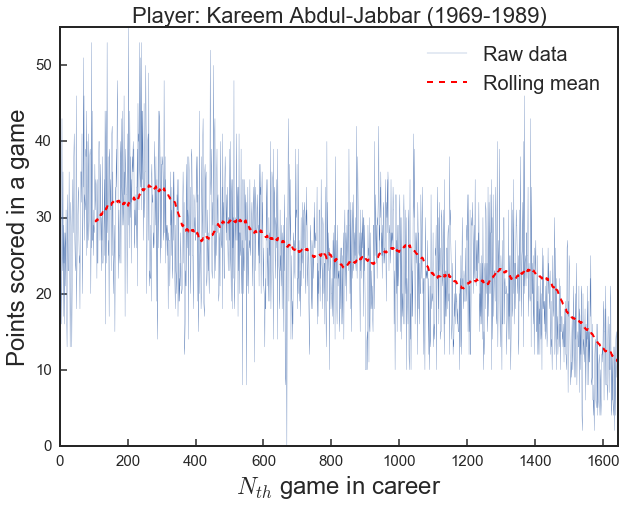

In [41]:

# Set size of a figure
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(10, 7.5))    
  
# Set axis   
ax = plt.subplot(111)   

# Set line width of axes
ax.spines["top"].set_linewidth(2)    
ax.spines["bottom"].set_linewidth(2)    
ax.spines["right"].set_linewidth(2)    
ax.spines["left"].set_linewidth(2) 


plt.tick_params(axis="both", which="both", bottom="on", top="off",    
labelbottom="on", left="on", right="off", labelleft="on",direction='in',length=7,width=1.5,pad=8,labelsize=20)

plt.yticks(range(0, 61, 10), [str(x) for x in range(0, 61, 10)], fontsize=15)    
plt.xticks(range(0,1800,200), [str(x) for x in range(0,1800,200)], fontsize=15) 








# First import Kareem's "Points per game" data from 1969-1989 
Scores        = pd.read_csv('./raw-data/Kareem_All_GameLog.csv')[["PTS"]].replace('Did Not Play','0')
Scores['PTS'] = Scores['PTS'].map(lambda x: Str2float(x))
Scores        = Scores[ Scores['PTS'].map(lambda x: type(x) is float)]
# Total length of the data set
print len( Scores )
# Plot time series of scores
plt.plot(Scores,lw=0.3, label='Raw data')
plt.plot(pd.rolling_mean(Scores, 100),linestyle='--',lw=2,c='r', label='Rolling mean')
plt.xlabel('$N_{th}$ game in career',fontsize=24)
plt.ylabel('Points scored in a game',fontsize=24)
plt.title('Player: Kareem Abdul-Jabbar (1969-1989)', fontsize=22)
plt.savefig('/Users/hidenori/Desktop/AM207_Kareem_Data.pdf', bbox_inches='tight',format='pdf')
plt.legend(loc=1,fontsize='20')

## 1st order Markov Model
To begin with, let's start with 1st order Markov Model, in which we estimate the result of this game only based on the last game.

The good thing about this first order Markov Model is that, we can create reasonable transition matrix with small data sets. Each NBA player plays in 82 games at most and for example if we use 2 years of data which is around 160, and classify player's conditoin with 5 levels, total elements of transitoin matrix becomes 25. Given 160 data, 25 matrix is already at the border to have reliability. If we want to go higher order, we have to construct bigger matrix and in which case we don't have enough data.

In [42]:
# Change Scores into numpy array
Scores = np.array(Scores['PTS']).astype(float)
# States
States = np.zeros( len(Scores) )

# Use 300th to 1000th games to train transition matrix
train_start = 300
train_end   = 1000

# Use 1000th to 1200th games to test the validity of transition matrix
test_start  = 1000
test_end    = 1200

# Mean of scores
MeanScore = np.mean(Scores[ train_start : train_end ])
# Variance of scores
StdScore  = np.std(Scores[ train_start : train_end ])

print 'Mean of score is ',     MeanScore
print 'Standard deviation of score is ', StdScore

Mean of score is  26.1985714286
Standard deviation of score is  7.00381514109


In [49]:
# To classify player's condition into 4 states, calculate Mean score +(-) 0.55*Std
PlusVar = MeanScore + 0.55*StdScore
MinusVar= MeanScore - 0.55*StdScore

print PlusVar, MeanScore, MinusVar

30.0506697562 26.1985714286 22.346473101


## Classification of player's condition
To classify condition of each player, we use training data and first calculate mean($\mu$) and standard deviation($\sigma$) of "Score per game".

Then we define 4 player's condition, "Best", "Better", "Worse", "Worst".
If player's score in $i_{th}$ game is $S_i$, condition of player $C_i$ is

### Best $ C_i = 3\,\, \rm{if} \,\, \mu+0.55\sigma<S_i$
### Better $ C_i = 2\,\, \rm{if} \,\, \mu<S_i<\mu+0.55\sigma$
### Worse $ C_i = 1\,\, \rm{if} \,\, \mu-0.55\sigma<S_i<\mu$
### Worst $ C_i = 0\,\, \rm{if} \,\, S_i<\mu-0.55\sigma$

We chose the number $0.55 \sigma$ so that 4 states are equally distributed. 

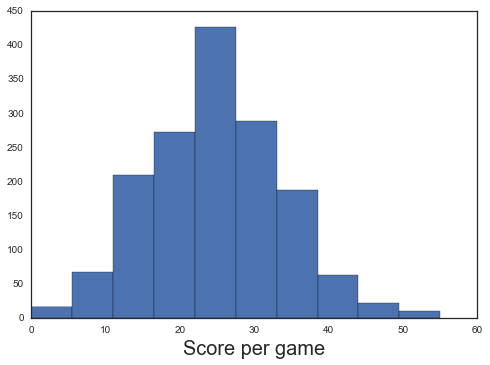

In [64]:
# Histogram of Score distribution
plt.hist(Scores,bins=10)
plt.xlabel("Score per game",fontsize=20)

## Classify Results into "States"

In [70]:
for i in range( len(States) ):
    # if a player score more than "average + Var/2", the player is in the best condition
    if PlusVar    <= Scores[i]:
        States[i] = 3
    
    # if a player score more than "average" but less than "average + Var/2", the player is in the good condition
    elif MeanScore<= Scores[i] < PlusVar:
        States[i] = 2
    
    # if a player score less than "average" but more than "average - Var/2", the player is in the worse condition
    elif MinusVar <= Scores[i] < MeanScore: 
        States[i] = 1

    # if a player score less than "average - Var/2", 
    elif Scores[i] < MinusVar:
        States[i] = 0

# We train 1st order transition matrix from first 900 matches
States_train = States[ train_start : train_end ]
# We test prediction  ability with 900-1000 data
States_test  = States[ test_start : test_end ]
    
Tmatrix1 = np.zeros([4,4])

# Learn from training data to construt transition matrix
for i in range(0,len(States_train)-1):
    Tmatrix1[ States_train[i] ][ States_train[i+1] ] += 1
print "This is transition matrix based on 1st order Markov chain\n",Tmatrix1,"\n\n"

print "Confirm 4 states are roughly equally distributed."
print "State1",np.sum( Tmatrix1[0] )/np.sum( Tmatrix1 )
print "State2",np.sum( Tmatrix1[1] )/np.sum( Tmatrix1 )
print "State3",np.sum( Tmatrix1[2] )/np.sum( Tmatrix1 )
print "State4",np.sum( Tmatrix1[3] )/np.sum( Tmatrix1 )


This is transition matrix based on 1st order Markov chain
[[ 73.  42.  44.  50.]
 [ 51.  27.  38.  29.]
 [ 44.  40.  33.  45.]
 [ 42.  36.  46.  59.]] 


Confirm 4 states are roughly equally distributed.
State1 0.298998569385
State2 0.207439198856
State3 0.231759656652
State4 0.261802575107


/Users/hidenori/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


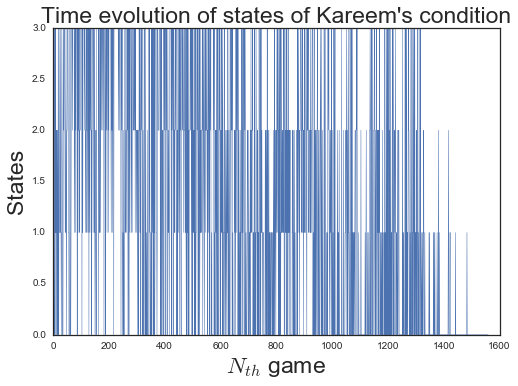

In [85]:
plt.plot( States ,lw=0.5)
plt.title("Time evolution of states of Kareem's condition", fontsize=23)
plt.ylabel("States",fontsize=23)
plt.xlabel("$N_{th}$ game", fontsize=23)

### Test the prediciton ability of the 1st order Markov Model

In [71]:
# Count how many times did the prediction gave "Correct" or "Wrong" answers.
Correct = 0
Wrong   = 0

for i in range(0,len(States_test)-1):
    # Always predict future by taking most probable transition from transition matrix
    if np.argmax( Tmatrix1[ int( States_test[i] ) ] ) == States_test[i+1]:
        # If the prediction is correct
        Correct +=1
        # If the prediction is not correct
    else:
        Wrong += 1
print 'Probability for getting next State right is ', float( Correct )/(Correct+Wrong)

Probability for getting next State right is  0.482412060302


## 2nd order Markov Model
We also try 2nd order Markov Model to check if it can give better prediction.
Now the transition matrix is $25 \times 25$ transition matrix. (based on results from recent two games, predict the result of the next game)

In [74]:
# Construct second order transition matrix
Tmatrix2=np.zeros([16,16])

# Use training data to construct the transition matrix
for i in range(len(States_train)-1):
    Tmatrix2[ 4*States_train[i-1] + States_train[i] ][ 4*States_train[i] + States_train[i+1] ] +=1

# normalize
for i in range(16):
    if Tmatrix2[i].sum() != 0:
        Tmatrix2[i]=Tmatrix2[i]#/Tmatrix2[i].sum()
print "This is the transition matrix for the 2nd order Markov Model\n", Tmatrix2

This is the transition matrix for the 2nd order Markov Model
[[ 32.  10.  13.  18.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  18.   7.  10.   7.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  15.  13.   9.   8.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.  11.
   11.  18.]
 [ 15.  10.  14.  12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  10.   3.   8.   6.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  10.  12.  10.   6.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   8.
    7.   8.]
 [ 13.   9.   9.  12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  14.   7.  12.   7.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   8.   4.  10.  11.   0.   0.
    0.   0.]
 [  

/Users/hidenori/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Test the prediction ability of 2nd order Markov Model

In [75]:
# Count how many times does the prediction give "Correct" or "Wrong" Answer
Correct = 0
Wrong   = 0

# Use the test data to check the probability of 2nd order Markov Model giving a right answer.
for i in range(1,len(States_test)-1):
    if np.mod( np.argmax( Tmatrix2[ int( States_test[i-1]*4 + States_test[i] ) ] ), 4) == States_test[i+1]:
        Correct +=1
    else:
        Wrong += 1
print "The probability of giving a right answer is " ,float( Correct )/(Correct+Wrong)

The probability of giving a right answer is  0.510101010101


# Conclusion
## Both 1st and 2nd order Markov model gave prediciton of condition with around 50% accuracy.

# Time Series Analysis in Longer Scale:
In the previous section we analyzed "condition" of each player using 2nd order Markov model, which takes results from recent two games to predict result for "next game".

When selecting the best member, another important factor when determining the team member is how do the player do in the "next year".

These trend can be partially affected by the player's age.

For example, some young player may be in the process of growing and the scores getting better and better every year, in which case we can expect for him to do better in comming year.

On the other hand, some great player's scores may be getting worse due to several reasons such as injury or aging.

To analyze these time series data to predict future out come, here we analyze "Point Per Game" data of "Kareem Abdul-Jabbar" who played from 1969 to 1989.

Refering to Lecture 17 "TimeSeries", we conduct inference and prediction with the data


# Time Series Analysis in Longer Scale: with ARMA model
In the previous section, we analyzed "condition" of each player using 2nd order Markov model, which takes results from recent two games to predict result for "next game".

Howevery, fans also say "this player is not doing well these 10 games or this entire year".

To capture these trends, we first average results of every 20 games and use techniques for time series analysis to predict out come from next 20-30 games.

First, we plotted "Autocorrelation" and "Partial Autocorrelation below".

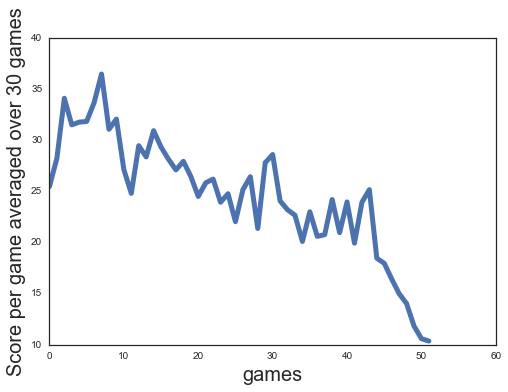

In [88]:
# In order to see the middle term (time scale of around a few month) trend, first we roll up the data for every 30 games
games=30

# AveScores => Score averaged over every 30 games
AveScores=np.zeros(len(Scores)/games)
i=0
j=0
for j in range(len(AveScores)):
    AveScores[j]=np.sum(Scores[i:i+games])/games
    i+=games
    j+=1
    
# Plot averaged score
plt.plot(AveScores,lw='5')
plt.xlabel('games', fontsize = 20)
plt.ylabel('Score per game averaged over '+str(games)+' games', fontsize =20)

## Check Autocorrelation

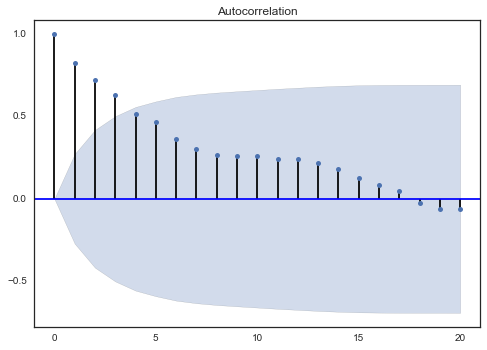

In [90]:
tsaplots.plot_acf( AveScores  , lags=20);

## Check Partial Autocorrelation

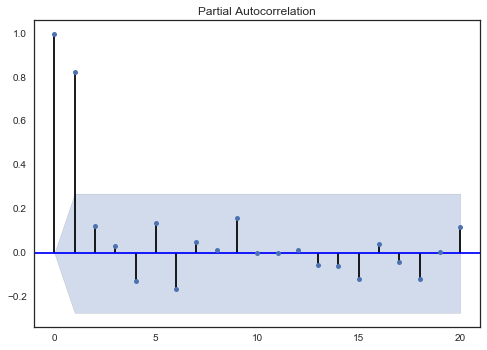

In [91]:
tsaplots.plot_pacf( AveScores , lags=20);

# Prediction with ARMA model 

array([ 222.04956772,  193.26431784,  194.16666864,  194.95313142,
        195.33665792,  195.44063739,  196.44373534,  198.35961651,
        200.32624631,  202.15171142,  203.98593807,  205.47861208,
        207.46585424,  206.4810676 ])

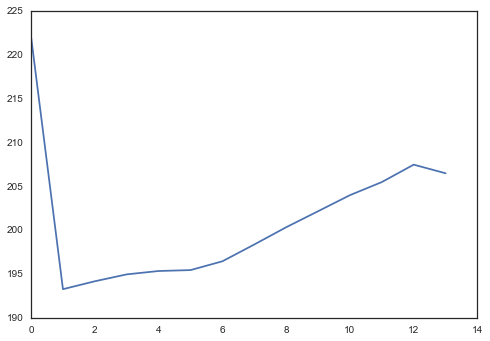

In [92]:
# We use first 39 data to train 
AveScores_train = AveScores[:39]
AveScores_test  = AveScores[39:]

# Based on plots of Autocorrelation and Partial Autocorrelation, use 14th order model
aics=np.zeros(14)
orders=range(14)
fits=[]
for j in orders:
    fit=sm.tsa.ARMA( AveScores_train , (j,0)).fit(method="mle")
    fits.append(fit)
    aics[j]=fit.aic
plt.plot(orders, aics);
aics

In [94]:
fits[10].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   39
Model:                    ARMA(10, 0)   Log Likelihood                 -89.993
Method:                           mle   S.D. of innovations              2.379
Date:                Thu, 05 May 2016   AIC                            203.986
Time:                        14:37:27   BIC                            223.949
Sample:                             0   HQIC                           211.148
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         26.4506      1.977     13.379      0.000        22.576    30.326
ar.L1.y        0.6868      0.163      4.219      0.000         0.368     1.006
ar.L2.y       -0.0395      0.200     -0.198      0.845        -0.431     0.352
ar.L3.y        0.3294      0.209      1.577      0.126        -0.080     0.739
ar.L4.y       -0.3615      0.210     -1.722      0.096        -0.773     0.050
ar.L5.y        0.3821      0.222      1.724      0.096        -0.052     0.817
ar.L6.y       -0.2556      0.219     -1.167      0.253        -0.685     0.174
ar.L7.y        0.0550      0.213      0.258      0.798        -0.362     0.472
ar.L8.y       -0.0073      0.215     -0.034      0.973        -0.429     0.414
ar.L9.y        0.1201      0.216      0.555      0.583        -0.304     0.544
ar.L10.y      -0.0798      0.196     -0.408      0.686        -0.463     0.303
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0718           -0.7298j            1.2967           -0.4049
AR.2            -1.0718           +0.7298j            1.2967            0.4049
AR.3            -0.7785           -0.9628j            1.2382           -0.3582
AR.4            -0.7785           +0.9628j            1.2382            0.3582
AR.5             0.2190           -1.2191j            1.2386           -0.2217
AR.6             0.2190           +1.2191j            1.2386            0.2217
AR.7             1.0644           -0.8489j            1.3614           -0.1071
AR.8             1.0644           +0.8489j            1.3614            0.1071
AR.9             1.1441           -0.0000j            1.1441           -0.0000
AR.10            1.4942           -0.0000j            1.4942           -0.0000
------------------------------------------------------------------------------
"""

# Result of prediction
Here we show the result of prediction below.
The plot shows that we can make reasonable prediction for near future. (comming 20-30 games)

This way of prediciton can be useful when choseing players to construct a team in Fantasy football.

### Import tableau20 colors as RGB to create "nice" plot

In [101]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (227,119,194),(152, 223, 138), (227, 119, 194),(255, 127, 14),(247,182,210),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

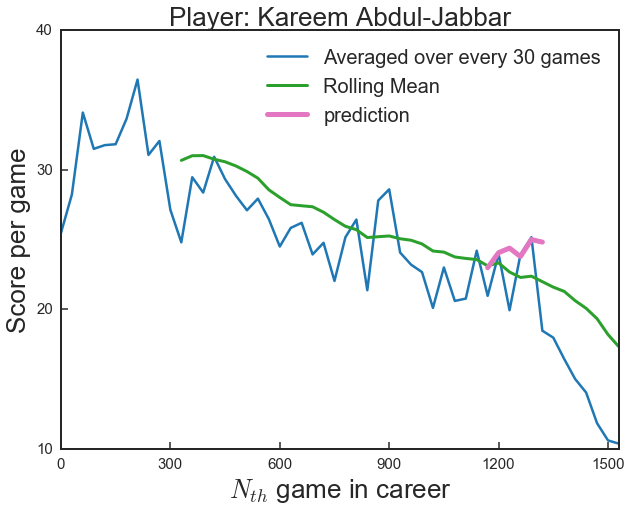

In [106]:
from statsmodels.tsa.stattools import adfuller

# Set size of a figure
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(10, 7.5))    
  
# Set axis   
ax = plt.subplot(111)   

# Set line width of axes
ax.spines["top"].set_linewidth(2)    
ax.spines["bottom"].set_linewidth(2)    
ax.spines["right"].set_linewidth(2)    
ax.spines["left"].set_linewidth(2) 

# Take care tick parameters for better plot
plt.tick_params(axis="both", which="both", bottom="on", top="off",    
labelbottom="on", left="on", right="off", labelleft="on",direction='in',length=7,width=1.5,pad=8,labelsize=20)
  



# import time series
timeseries = AveScores
#Determing rolling statistics
rolmean = pd.rolling_mean(timeseries, window=12)
rolstd = pd.rolling_std(timeseries, window=12)

plt.yticks(range(10, 41, 10), [str(x) for x in range(10, 41, 10)], fontsize=15)    
plt.xticks(range(0,60,10), [str(x) for x in range(0,1800,300)], fontsize=15) 

#Plot rolling statistics:
plt.plot(AveScores,marker='o',markersize=0, markeredgewidth=1.0,markeredgecolor=tableau20[1] ,lw=2.5,linestyle='-',markerfacecolor="None",color=tableau20[0],alpha=1.0,label= "Averaged over every 30 games")
mean = plt.plot(rolmean, color=tableau20[6],lw='3', label='Rolling Mean')

plt.ylim(10,40)
plt.plot(index_rem, predicts,lw=5,color=tableau20[3],label = "prediction")
plt.legend(loc='best',fontsize='20')
plt.xlabel(r'$N_{th}$ game in career',fontsize=26)
plt.ylabel('Score per game',fontsize=26)
plt.title('Player: Kareem Abdul-Jabbar', fontsize=26)
plt.savefig('/Users/hidenori/Desktop/AM207_Kareem.pdf', bbox_inches='tight',format='pdf')



# Result of prediction

The plot below shows two interesting results.
### 1. ARMA model captured characteristic behaviour of the plot and gave reasonable prediction


### 2. Rolling mean showing result of aging.
The green curve is the rolling mean of points per game of Kareem's entire career.
Due to the effect of aging, it showing continuous decreasing of Points per game after certain amoung of time.